<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">Market SPX ATM-Skew</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

In [3]:
import numpy as np
import matplotlib.pyplot as plt

We start with the values below of the average term structure  of SPX ATM skew computed on the market between 2012 and 2023:	$$T \to \partial_k\sigma_{iv}(T,k)\mid_{k=0}$$
in absolute value (the values are actually negative). 

In [5]:
# For maturities up to 2 months.
maturity_T_short = [0.019178082, 0.021917808, 0.024657534, 0.02739726, 0.030136986, 0.032876712, 0.035616438, 0.038356164, 0.04109589, 0.043835616, 0.046575342, 0.052054795, 0.054794521, 0.060273973, 0.065753425, 0.071232877, 0.079452055, 0.084931507, 0.095890411, 0.104109589, 0.117808219, 0.131506849, 0.145205479, 0.161643836]
ATMF_skew_short = [ 1.41534232, 1.386147735, 1.362595864, 1.333019126, 1.309943735, 1.272588202, 1.271921974, 1.24562506, 1.21920028, 1.207121308, 1.190525348, 1.168823457, 1.175209697, 1.119833268, 1.091778815, 1.079876151, 1.029579184, 1.007916359, 0.968841529, 0.944388875, 0.896986369, 0.854127688, 0.830539976, 0.796041492]

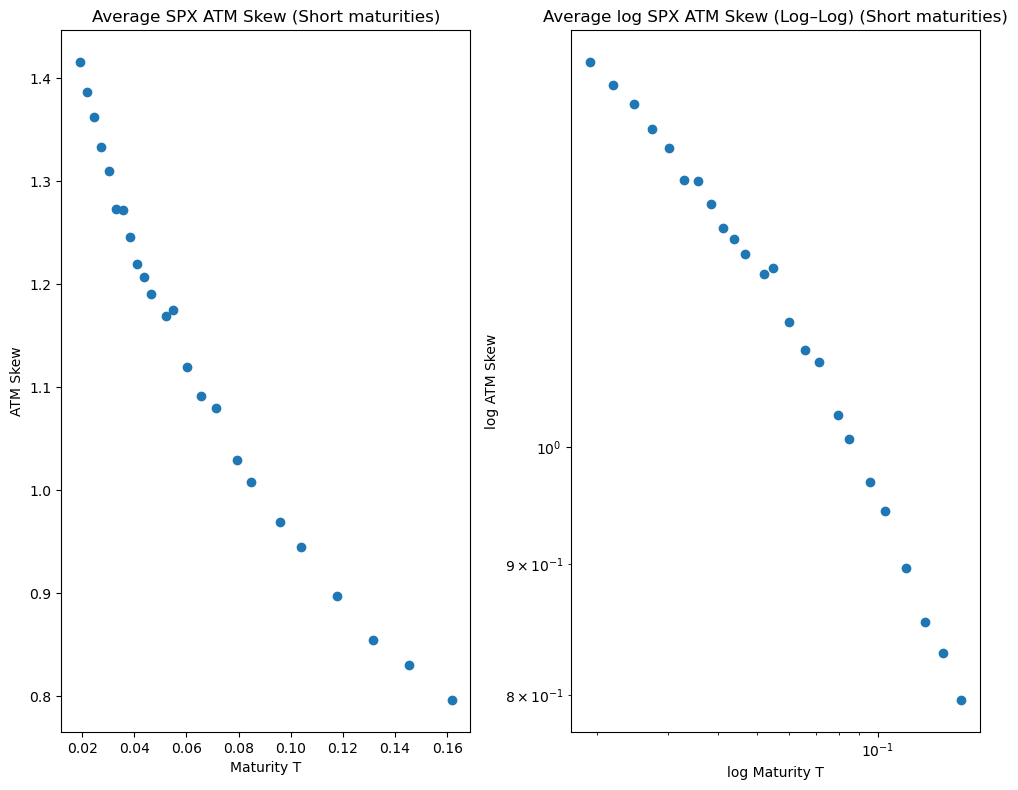

In [7]:
plt.figure(figsize=(10, 8))
# plot for maturities up to 3 months
plt.subplot(1, 2, 1)
plt.plot(maturity_T_short, ATMF_skew_short, 'o')
plt.title("Average SPX ATM Skew (Short maturities)")
plt.xlabel("Maturity T")
plt.ylabel("ATM Skew")

# Log–log plot
plt.subplot(1, 2, 2)
plt.loglog(maturity_T_short, ATMF_skew_short, 'o')
plt.title("Average log SPX ATM Skew (Log–Log) (Short maturities)")
plt.xlabel("log Maturity T")
plt.ylabel("log ATM Skew")

plt.tight_layout()
plt.show()


## We consider three parametric shapes of the skew: 
- $S_{exp}(T) = \frac{c_1}{T}(1-\frac{1-e^{-\lambda_1 T}}{\lambda_1 T})$ $\lambda_1, c_1 >0$. 
-  $S_{frac}(T) = cT^{\beta}$, $\beta > -0.5$,
-  $S_{shifted}(T) = \frac{c}{T^2} (\frac{(\alpha + T)^{\beta+2}}{\beta+2} - \frac{\alpha^{\beta+2}}{\beta+2} - \alpha^{\beta +1 } T ), \beta >-1. $

For $S_{shifted}$ we will keep $\alpha=1/52$ fixed. 

Calibrating to `ATMF_skew_short`  $S_{exp}, S_{frac}, S_{shifted} $ gives the following  coefficient:


In [11]:
import pandas as pd

# Pre-calibrated short-maturity ATM skew parameters
df_short = pd.DataFrame({
    "model": ["S_exp", "S_frac", "S_shifted"],
    "c1": [0.192483, np.nan, np.nan],
    "lambda1": [15.828011, np.nan, np.nan],
    "rmse": [0.016785, 0.028162, 0.009430],
    "c": [np.nan, 0.531360, 0.714311],
    "beta": [np.nan, -0.257128, -0.700098],
    "alpha": [np.nan, np.nan, 0.019231],
})
df_short

,model,c1,lambda1,rmse,c,beta,alpha
0,S_exp,0.192483,15.828011,0.016785,NaN,NaN,NaN
1,S_frac,NaN,NaN,0.028162,0.531360,-0.257128,NaN
2,S_shifted,NaN,NaN,0.009430,0.714311,-0.700098,0.019231


<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">Is volatility rough?</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

The aim of this section is to investigate the question *“Is volatility rough?”* through a numerical experiment conducted in the spirit of Section 6 of Abi Jaber and Li (2024).

We consider three volatility models calibrated to the short-maturity ATM skew and estimate the Hölder regularity (or roughness) of their simulated volatility trajectories using the methodology of Gatheral, Jaisson, and Rosenbaum (2018). In particular, we rely on empirical $q$-variations and log–log regressions to obtain statistical estimates of the Hurst exponent.

The volatility dynamics are simulated within the Volterra framework using the iVi scheme introduced by Abi Jaber and Attal (2025), which allows for stable and positivity-preserving simulation even in the presence of singular kernels. Representative sample paths of the spot variance process $V$ are generated for each calibrated model.

Our objective is to compare the statistically estimated Hurst exponents with the theoretical roughness implied by the short-maturity skew asymptotics.

More fundamentally, we aim to address the following questions:

- Does observing statistical roughness necessarily imply intrinsic roughness of the spot volatility process?
- Is roughness a genuine stylized fact of volatility, or can it arise as an artifact of mean-reversion, discretization, or proxy construction?
- Can one reliably distinguish, based on finite sample paths, between fast mean-reverting dynamics, spiky behavior, and genuinely rough volatility?
- What are the potential risks, from an option pricing perspective, of concluding that volatility is truly rough and modeling it accordingly?

## Implicit Estimation of the Hurst Exponent from the Short-Term Skew

We exploit the short-maturity ATM (at-the-money) skew calibration in order to derive an implicit structural estimate of the Hurst exponent.

In Volterra–Heston models with fractional-type kernels, short-maturity asymptotics predict that as $T \to 0$:

$$
\text{Skew}_{ATM}(T) \sim C\, T^{H-\frac{1}{2}},
$$

where $H$ characterizes the local regularity of the variance (or volatility) process.

In our short-end calibration, the fitted forms are of power-law type:

- **Fractional model:**
$$
\text{Skew}_{ATM}(T) \approx c\, T^{\beta},
$$

- **Shifted power-law model:**
$$
\text{Skew}_{ATM}(T) \approx c\, (T+\alpha)^{\beta}.
$$

By identifying the exponents, we obtain:

$$
\beta \approx H - \frac{1}{2}
\quad \Longrightarrow \quad
H_{\text{skew}} = \beta + \frac{1}{2}.
$$

This relationship provides a structural implicit estimate of the Hurst exponent derived from the short-maturity behavior of the skew.

### Exponential Model Case

The exponential model $S_{\exp}$ corresponds to the classical Markovian case (standard Heston model), associated with an exponential kernel

$$
K(t) = c_1 e^{-\lambda_1 t}.
$$

In this case, the skew does not follow a power-law behavior of the form $T^{H-\frac{1}{2}}$ as $T \to 0$.  
The variance process is a classical semimartingale, and its local regularity corresponds to the standard Brownian case.

Therefore, the effective regularity exponent can be taken as:

$$
H = \frac{1}{2}.
$$

Thus:
- for power-law-type models: $H_{\text{skew}} = \beta + \tfrac{1}{2}$ ;
- for the exponential (Markovian Heston) model: $H_{\text{skew}} = 0.5$.

In [16]:
df_short["H_skew"] = np.where(
    df_short["beta"].notna(),
    df_short["beta"] + 0.5,
    0.5  # exponential (Markovian Heston) case
)

df_short

,model,c1,lambda1,rmse,c,beta,alpha,H_skew
0,S_exp,0.192483,15.828011,0.016785,NaN,NaN,NaN,0.500000
1,S_frac,NaN,NaN,0.028162,0.531360,-0.257128,NaN,0.242872
2,S_shifted,NaN,NaN,0.009430,0.714311,-0.700098,0.019231,-0.200098


## Simulation of the Integrated Variance Process via the iVi Scheme

In order to estimate the effective regularity of volatility trajectories, we must simulate the dynamics of the calibrated models.  
Within the Volterra–Heston framework, the variance process is not necessarily Markovian and can be defined through a Volterra-type stochastic equation.

We consider a variance process $V$ defined by the stochastic Volterra equation:

$$
V_t = g_0(t)
+ \int_0^t K(t-s)\, b\, V_s \, ds
+ \int_0^t K(t-s)\, c \sqrt{V_s}\, dW_s,
$$

where:

- $K : \mathbb{R}_+ \to \mathbb{R}_+$ is a locally integrable kernel (not necessarily in $L^2$),
- $b \le 0$ and $c \ge 0$ are parameters,
- $g_0$ is a non-negative deterministic input curve,
- $W$ is a standard Brownian motion.

Depending on the choice of kernel $K$:

- $K(t) = c_1 e^{-\lambda_1 t}$ corresponds to the Markovian Heston model,
- $K(t) = \dfrac{t^{H-\frac12}}{\Gamma(H+\frac12)}$ corresponds to the rough Heston model,
- $K(t) = \dfrac{(t+\alpha)^{H-\frac12}}{\Gamma(H+\frac12)}$ corresponds to the shifted power-law model (possibly hyper-rough).

---

### Integrated Formulation

It is numerically more stable to work with the integrated variance process

$$
U_t = \int_0^t V_s\, ds.
$$

Integrating the previous equation and applying stochastic Fubini’s theorem, one obtains the Volterra equation for $U$:

$$
U_t
=
\int_0^t g_0(s)\, ds
+
\int_0^t K(t-s)\,\big( b\, U_s + c\, Z_s \big)\, ds,
$$

where

$$
Z_t = \int_0^t \sqrt{V_s}\, dW_s
$$

is a continuous martingale with quadratic variation $\langle Z \rangle_t = U_t$.

This formulation is particularly convenient when the kernel $K$ is singular (fractional case) or only belongs to $L^1$.

---

### Simulation Scheme: iVi (Abi Jaber & Attal, 2025)

To simulate the integrated process $U$, we use the **iVi (integrated Volterra implicit)** scheme proposed by Abi Jaber and Attal (2025).

The central idea of the scheme is:

- to simulate directly the increments of $U$,
- to preserve monotonicity ($U$ is increasing),
- to handle singular kernels efficiently,
- and to avoid explicitly reconstructing $V$ whenever unnecessary.

On a uniform grid $t_i = iT/n$, the scheme recursively simulates the increments

$$
U_{t_i,t_{i+1}} = U_{t_{i+1}} - U_{t_i}
$$

via an Inverse Gaussian distribution whose parameters depend on the integrated kernel coefficients

$$
k_\ell = \int_0^{\Delta t} K(\ell \Delta t + s)\, ds.
$$

This scheme:

- preserves positivity of $U$,
- converges weakly to the solution of the Volterra equation,
- and remains stable even when $H \to -\frac12$.

In the following, we use it to simulate trajectories of the integrated process $U$, then reconstruct a discrete approximation of the instantaneous variance in order to estimate its empirical regularity.

In [19]:
# -----------------------------
# Inverse Gaussian sampler (Algorithm 2 in the iVi paper)
# X ~ IG(mu, lam) with mean parameter mu > 0 and shape parameter lam > 0
# -----------------------------
def sample_inverse_gaussian(mu: float, lam: float, rng: np.random.Generator) -> float:
    """
    Sample from Inverse Gaussian IG(mu, lam) with density:
        f(x; mu, lam) = sqrt(lam/(2*pi*x^3)) * exp(-lam (x-mu)^2 / (2*mu^2*x)), x>0

    Uses Michael–Schucany–Haas (1976), as recalled in Algorithm 2 of the paper.
    """
    if mu <= 0 or lam <= 0:
        # Convention: IG(0,0)=delta_0 ; here we just return 0 for degenerate cases
        return 0.0

    xi = rng.standard_normal()
    y = xi * xi
    # Candidate X
    x = mu + (mu * mu * y) / (2.0 * lam) - (mu / (2.0 * lam)) * np.sqrt(4.0 * mu * lam * y + (mu * mu) * (y * y))
    u = rng.random()
    if u <= mu / (mu + x):
        return float(x)
    else:
        return float((mu * mu) / x)


# -----------------------------
# Compute integrated kernel coefficients k_ell (Eq. (0.5))
# k_ell = ∫_0^{dt} K(ell*dt + s) ds
# -----------------------------
def compute_k_coeffs(K, dt: float, n: int, quad_steps: int = 64) -> np.ndarray:
    """
    Numerical integration (trapezoidal rule) to compute k_ell for ell=0..n-1.
    K must accept numpy arrays and return numpy arrays.
    """
    s = np.linspace(0.0, dt, quad_steps)
    ks = np.zeros(n, dtype=float)

    for ell in range(n):
        t = ell * dt + s
        vals = K(t)
        # trapz over s
        ks[ell] = np.trapz(vals, s)

    return ks
# -----------------------------
# iVi scheme (Algorithm 1): simulate increments U_hat_{i,i+1}, Z_hat_{i,i+1}
# -----------------------------
def ivi_simulate_UZ(
    K,
    g0,
    b: float,
    c: float,
    T: float = 1.0,
    n: int = 252,
    quad_steps: int = 64,
    seed: int | None = None,
):
    """
    Implements Algorithm 1 (iVi scheme) for the integrated process U.

    Inputs:
      - K: kernel function K(t) >= 0, callable on numpy arrays
      - g0: input curve g0(t) >= 0, callable on numpy arrays
      - b <= 0, c >= 0
      - T: horizon
      - n: number of steps (uniform grid)
      - quad_steps: integration resolution for k_ell and for ∫_{t_i}^{t_{i+1}} g0(s) ds
      - seed: RNG seed

    Outputs:
      dict with:
        dt, t_grid,
        k (array k_ell),
        U_incr (n,), Z_incr (n,),
        U (n+1,), Z (n+1,), alpha (n,)
    """
    if c <= 0:
        raise ValueError("iVi scheme requires c > 0 (vol-of-vol).")
    if b > 0:
        raise ValueError("Assumption in the iVi paper is b <= 0.")
    rng = np.random.default_rng(seed)

    dt = T / n
    t_grid = np.linspace(0.0, T, n + 1)

    # Step 3: compute k_ell (Eq. (0.5))
    k = compute_k_coeffs(K, dt=dt, n=n, quad_steps=quad_steps)
    k0 = k[0]
    if k0 <= 0:
        raise ValueError("Need k0 > 0. Check your kernel K and integration settings.")
    if 1.0 - b * k0 <= 0:
        raise ValueError("Need 1 - b*k0 > 0 for IG mean parameter. Adjust b or kernel / dt.")

    # Precompute G_i = ∫_{t_i}^{t_{i+1}} g0(s) ds for all i
    # (This is the first term of alpha_i in Eq. (0.6))
    G = np.zeros(n, dtype=float)
    for i in range(n):
        s = np.linspace(t_grid[i], t_grid[i + 1], quad_steps)
        G[i] = np.trapz(g0(s), s)
        if G[i] < 0:
            raise ValueError("g0 must be nonnegative (numerically).")

    U_incr = np.zeros(n, dtype=float)
    Z_incr = np.zeros(n, dtype=float)
    alpha = np.zeros(n, dtype=float)

    # Step 4-8: recursion (Eq. (0.6)-(0.7)-(0.8))
    for i in range(n):
        if i == 0:
            alpha_i = G[0]
        else:
            # alpha_i = G[i] + sum_{j=0}^{i-1} k_{i-j} ( b U_{j,j+1} + c Z_{j,j+1} )
            # note: k_{i-j} uses index (i-j)
            conv = 0.0
            for j in range(i):
                conv += k[i - j] * (b * U_incr[j] + c * Z_incr[j])
            alpha_i = G[i] + conv

        # Numerical safety: alpha_i should be >= 0 (the scheme is designed to preserve it under assumptions)
        # but finite precision might produce tiny negatives; we clip at 0.
        if alpha_i < 0 and alpha_i > -1e-14:
            alpha_i = 0.0
        if alpha_i < 0:
            raise RuntimeError(f"alpha[{i}] became negative ({alpha_i}). Check (b,c,g0,K) and discretization.")

        alpha[i] = alpha_i

        mu_i = alpha_i / (1.0 - b * k0)
        lam_i = (alpha_i / (c * k0)) ** 2 if alpha_i > 0 else 0.0

        # Step 6: sample U_incr[i] ~ IG(mu_i, lam_i)
        Uii = sample_inverse_gaussian(mu_i, lam_i, rng)
        U_incr[i] = Uii

        # Step 7: set Z_incr
        Z_incr[i] = ((1.0 - b * k0) * Uii - alpha_i) / (c * k0)

    # Build cumulative processes U_t and Z_t on the grid
    U = np.zeros(n + 1, dtype=float)
    Z = np.zeros(n + 1, dtype=float)
    U[1:] = np.cumsum(U_incr)
    Z[1:] = np.cumsum(Z_incr)

    return {
        "dt": dt,
        "t_grid": t_grid,
        "k": k,
        "U_incr": U_incr,
        "Z_incr": Z_incr,
        "U": U,
        "Z": Z,
        "alpha": alpha,
    }

In [21]:
from scipy.special import gamma

# --- Kernel builder from df_short row ---
def make_kernel_from_row(row, eps=1e-12):
    model = row["model"]

    if model == "S_exp":
        c1 = float(row["c1"])
        lam1 = float(row["lambda1"])

        def K(t):
            t = np.asarray(t, dtype=float)
            return c1 * np.exp(-lam1 * t)

        meta = {
            "model": model,
            "kernel": "exponential (Markovian/Heston)",
            "c1": c1,
            "lambda1": lam1,
            "H_skew": 0.5,
        }
        return K, meta

    elif model == "S_frac":
        H = float(row["H_skew"])
        denom = gamma(H + 0.5)

        def K(t):
            t = np.asarray(t, dtype=float)
            t = np.maximum(t, eps)  # avoid 0^(negative) for plotting/integration stability
            return (t ** (H - 0.5)) / denom

        meta = {
            "model": model,
            "kernel": "fractional power-law",
            "H_skew": H,
            "beta": float(row["beta"]),
            "c_fit": float(row["c"]),
        }
        return K, meta

    elif model == "S_shifted":
        H = float(row["H_skew"])
        alpha = float(row["alpha"])
        denom = gamma(H + 0.5)

        def K(t):
            t = np.asarray(t, dtype=float)
            return ((t + alpha) ** (H - 0.5)) / denom

        meta = {
            "model": model,
            "kernel": "shifted power-law",
            "H_skew": H,
            "beta": float(row["beta"]),
            "alpha": alpha,
            "c_fit": float(row["c"]),
        }
        return K, meta

    else:
        raise ValueError(f"Unknown model: {model}")


# --- Variance proxy: ALWAYS spot proxy (everything well-defined here) ---
def build_variance_proxy(U_incr, dt, eps=1e-12):
    """
    Spot proxy for variance:
        V_i ≈ ΔU_i / Δt
    Returns:
      V_proxy (length n), method string, offset=1 so that tV = t_grid[1:].
    """
    V_proxy = np.maximum(U_incr / dt, eps)
    method = "spot proxy: V_i = ΔU/Δt"
    offset = 1
    return V_proxy, method, offset


# --- MAIN: simulate + plot for ONE kernel/model ---
def simulate_plot_one_kernel(
    df_short,
    model_name="S_exp",
    T=5.0,
    n=None,
    b=-0.3,
    c=0.2,
    V0=0.04,
    seed=123,
    show_kernel_shape=True,
):
    """
    Simulate one path using iVi for a selected model in df_short and plot:
      1) U(t) integrated variance
      2) variance proxy V_i ≈ ΔU/Δt
      3) (optional) kernel shape K(t) on a short time window

    Defaults: T=5 years, n=504*T steps unless provided.

    Returns a dict with t_grid, U, U_incr, V_proxy, meta, dt, etc.
    """
    if n is None:
        n = int(504 * T)

    # pick row
    row = df_short.loc[df_short["model"] == model_name]
    if row.empty:
        raise ValueError(f"model_name='{model_name}' not found in df_short['model']")
    row = row.iloc[0]

    # kernel
    K, meta = make_kernel_from_row(row)

    # g0 constant
    def g0(t):
        t = np.asarray(t, dtype=float)
        return V0 * np.ones_like(t)

    # simulate
    out = ivi_simulate_UZ(
        K=K,
        g0=g0,
        b=b,
        c=c,
        T=T,
        n=n,
        seed=seed
    )

    t = out["t_grid"]     # length n+1
    dt = out["dt"]
    U = out["U"]          # length n+1
    U_incr = out["U_incr"]  # length n

    # variance proxy (spot)
    V_proxy, proxy_method, offset = build_variance_proxy(U_incr=U_incr, dt=dt)
    tV = t[offset:]  # aligns with V_proxy, i.e., t_1..t_n

    # --- Plot U(t)
    plt.figure(figsize=(11, 4))
    plt.plot(t, U)
    title = f"Integrated variance U(t) | {meta['model']} | {meta['kernel']} | H_skew={meta['H_skew']:.6f}"
    plt.title(title)
    plt.xlabel("t (years)")
    plt.ylabel("U(t) = ∫₀ᵗ V_s ds")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- Plot variance proxy
    plt.figure(figsize=(11, 4))
    plt.plot(tV, V_proxy)
    plt.title(f"Variance proxy | {meta['model']} | {proxy_method}")
    plt.xlabel("t (years)")
    plt.ylabel("variance proxy")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- Optional: show kernel shape (recommend log-log for power-law kernels)
    if show_kernel_shape:
        plt.figure(figsize=(11, 4))
        tK = np.linspace(0.0, 0.25, 500)  # quarter year window
        plt.plot(tK, K(tK))
        plt.title(f"Kernel shape K(t) | {meta['model']} | window [0, 0.25] years")
        plt.xlabel("t (years)")
        plt.ylabel("K(t)")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Extra: log-log view helps for power-law kernels
        if meta["model"] in ("S_frac", "S_shifted"):
            plt.figure(figsize=(11, 4))
            tK2 = np.linspace(1e-6, 0.25, 500)
            plt.loglog(tK2, K(tK2))
            plt.title(f"Kernel shape K(t) (log-log) | {meta['model']} | window [1e-6, 0.25] years")
            plt.xlabel("t (years)")
            plt.ylabel("K(t)")
            plt.grid(True, which="both", alpha=0.3)
            plt.tight_layout()
            plt.show()

    return {
        "meta": meta,
        "dt": dt,
        "t_grid": t,
        "U": U,
        "U_incr": U_incr,
        "V_proxy": V_proxy,
        "tV": tV,
        "proxy_method": proxy_method,
        "out_raw": out,  # includes Z, alpha, k, etc.
    }

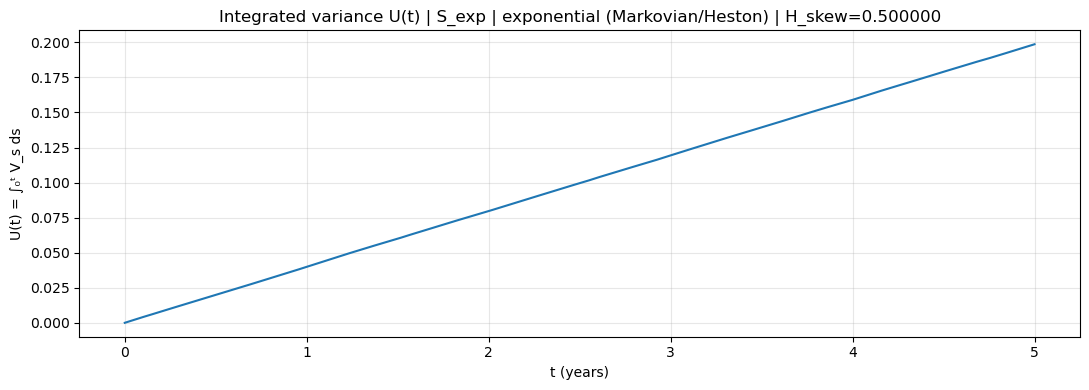

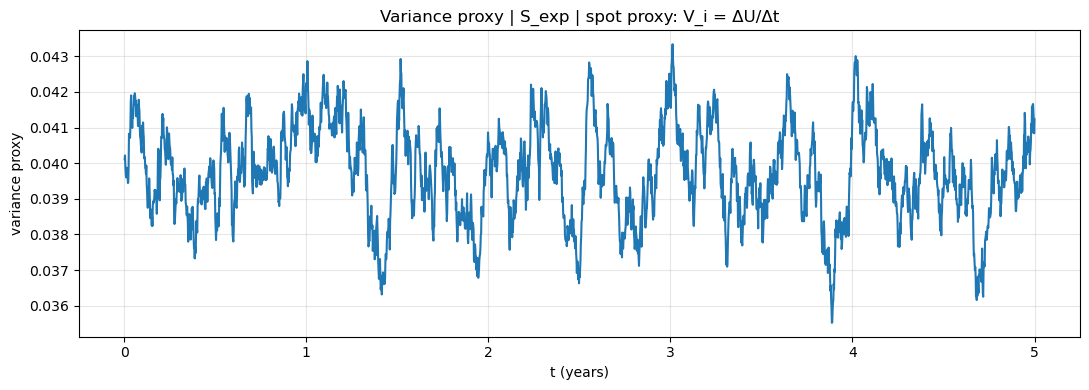

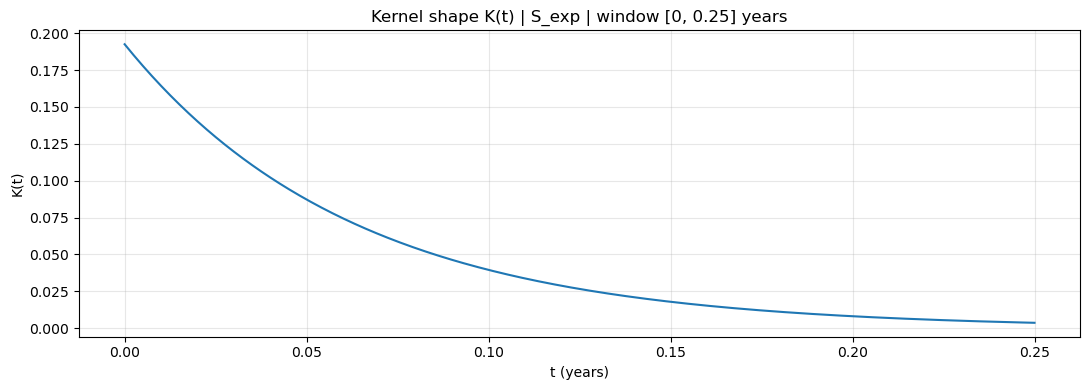

In [23]:
res_exp = simulate_plot_one_kernel(
    df_short=df_short,
    model_name="S_exp",
    T=5.0,
    n=504*5,
    seed=1
)
V_exp = res_exp["V_proxy"]
t_exp = res_exp["tV"]

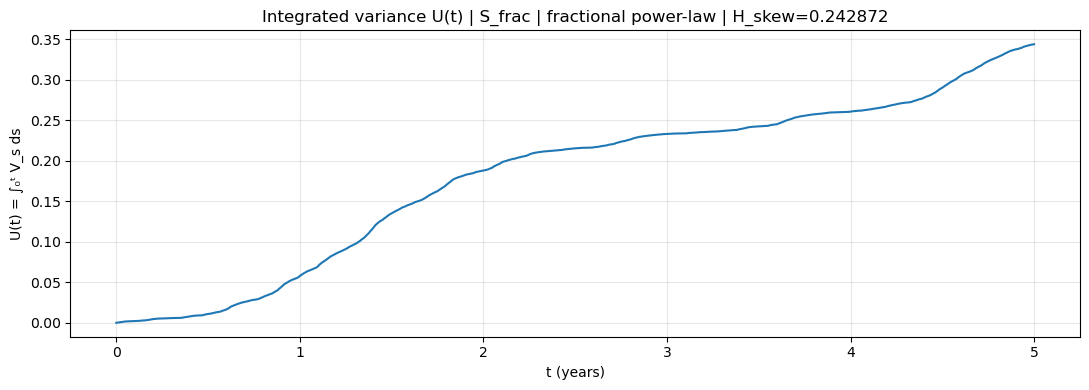

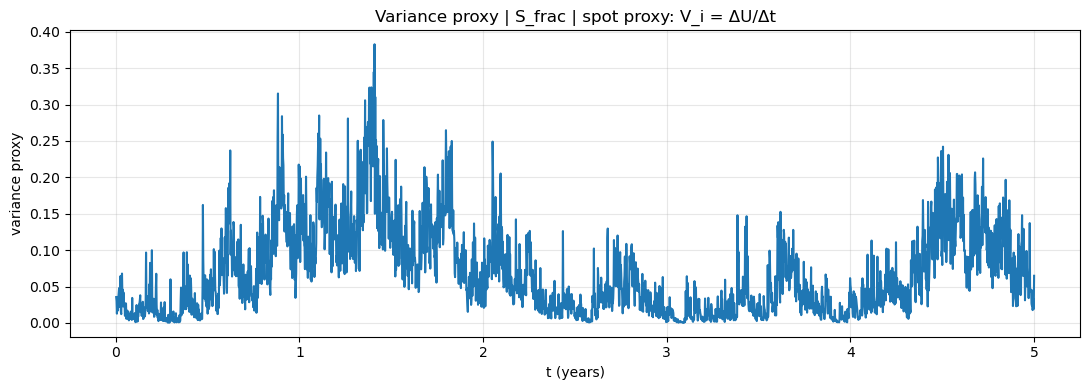

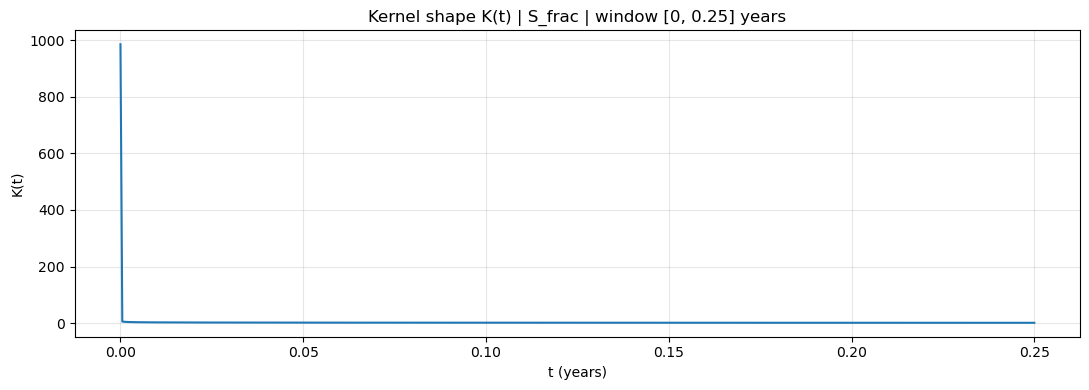

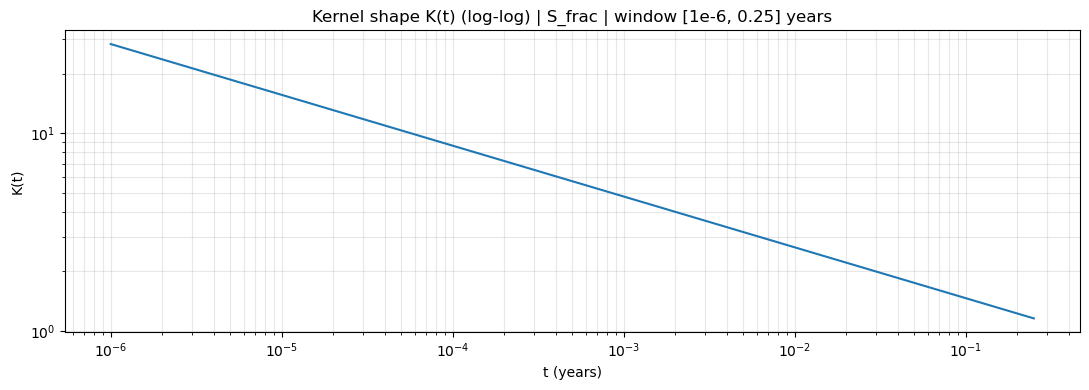

In [25]:
res_frac = simulate_plot_one_kernel(
    df_short=df_short,
    model_name="S_frac",
    T=5.0,
    n=504*5,
    seed=2
)

V_frac = res_frac["V_proxy"]
t_frac = res_frac["tV"]

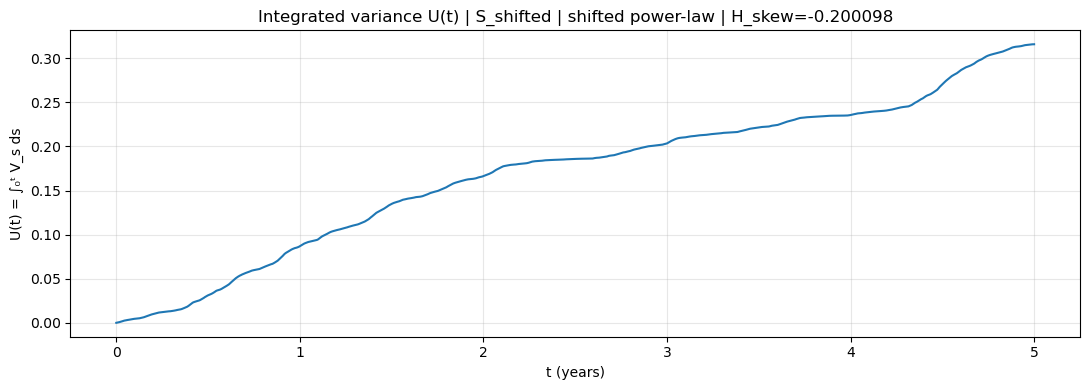

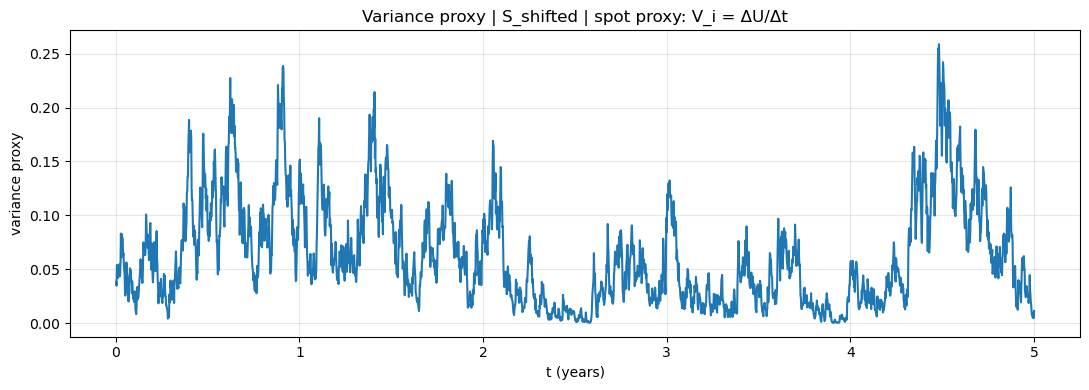

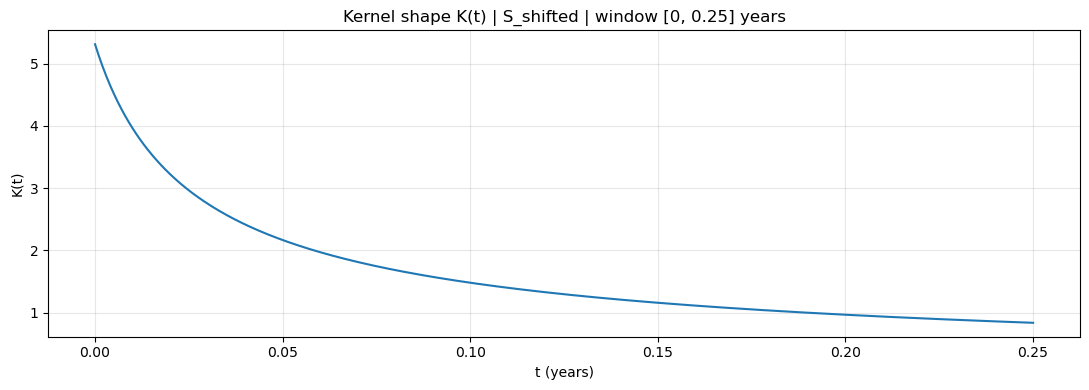

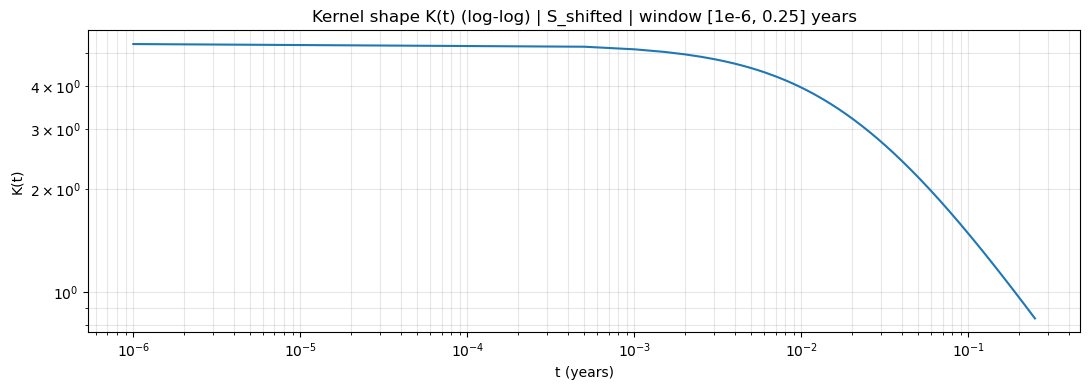

In [27]:
res_shift = simulate_plot_one_kernel(
    df_short=df_short,
    model_name="S_shifted",
    T=5.0,
    n=504*5,
    seed=2)

V_shift = res_shift["V_proxy"]
t_shift = res_shift["tV"]

In [ ]:
We will primarily work with the log-volatility (log-standard deviation) in what follows.

In [29]:
eps = 1e-12

# Vol proxy (std dev) + log-vol series X = log(sigma)
sigma_exp  = np.sqrt(np.maximum(V_exp,  eps))
sigma_frac = np.sqrt(np.maximum(V_frac, eps))
sigma_shift= np.sqrt(np.maximum(V_shift,eps))

X_exp   = np.log(np.maximum(sigma_exp,  eps))
X_frac  = np.log(np.maximum(sigma_frac, eps))
X_shift = np.log(np.maximum(sigma_shift,eps))

## Empirical Estimation of Regularity

We now implement the methodology for estimating the Hurst exponent inspired by Gatheral, Jaisson and Rosenbaum (2018).

Starting from the series
$$
X_t = \log(\sigma_t),
$$
we study the increment moments defined by
$$
m(q,\Delta)
=
\frac{1}{N-\Delta}
\sum_{i=0}^{N-\Delta-1}
\left| X_{i+\Delta} - X_i \right|^q,
$$
where $\Delta$ denotes a discrete lag (in number of time steps) and $q>0$ is the order of the moment.

Under a monofractal scaling regime, one expects a power-law behavior of the form
$$
m(q,\Delta) \sim C_q \Delta^{qH}.
$$

Taking logarithms leads to a linear relation:
$$
\log m(q,\Delta)
\approx
\log C_q + qH \log \Delta.
$$

The Hurst exponent can therefore be estimated from the slope of the linear regression of
$$
\log m(q,\Delta)
\quad \text{against} \quad
\log \Delta.
$$

We define below a set of generic functions that allow us to:

- efficiently compute $m(q,\Delta)$ for multiple values of $q$ and $\Delta$;
- graphically represent $\log m(q,\Delta)$ as a function of $\log \Delta$;
- estimate the exponent $\widehat H$ via log–log regression.

These tools will be applied successively to each of the three kernels under consideration.

In [31]:
def compute_log_mq_delta(X, deltas, qs, eps=1e-12):
    """
    log m(q, Δ) with:
        m(q, Δ) = mean_i |X_{i+Δ} - X_i|^q
    """
    X = np.asarray(X, dtype=float)
    n = X.shape[0]

    deltas = [int(d) for d in deltas if 0 < int(d) < n]
    qs = [float(q) for q in qs if float(q) > 0]

    m = np.full((len(qs), len(deltas)), np.nan, dtype=float)

    for j, D in enumerate(deltas):
        dX = np.abs(X[D:] - X[:-D])
        dX = dX[np.isfinite(dX)]
        if dX.size == 0:
            continue
        for i, q in enumerate(qs):
            m[i, j] = np.mean(dX ** q)

    log_m = np.log(np.maximum(m, eps))
    return log_m, m, deltas, qs

def plot_log_m_vs_log_delta(log_m, deltas, qs, title="", show=True):
    """
    One plot: y = log m(q,Δ) vs x = log Δ for multiple q (same kernel).
    """
    x = np.log(np.asarray(deltas, dtype=float))

    plt.figure(figsize=(9, 5))
    for i, q in enumerate(qs):
        y = log_m[i, :]
        plt.plot(x, y, marker="o", label=f"q={q:g}")
    plt.title(title)
    plt.xlabel(r"$\log \Delta$")
    plt.ylabel(r"$\log m(q,\Delta)$")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    if show:
        plt.show()

def estimate_H_per_q(log_m, deltas, qs, fit_range=None):
    """
    For each q: regress log m(q,Δ) on log Δ and return H_hat(q)=slope/q.

    fit_range: optional tuple (Δ_min, Δ_max) in *integer steps* to restrict regression.
    """
    deltas = np.asarray(deltas, dtype=float)
    x = np.log(deltas)

    if fit_range is not None:
        dmin, dmax = fit_range
        mask = (deltas >= dmin) & (deltas <= dmax)
    else:
        mask = np.ones_like(deltas, dtype=bool)

    H_hats = {}
    slopes = {}

    for i, q in enumerate(qs):
        y = log_m[i, :]
        xm = x[mask]
        ym = y[mask]
        good = np.isfinite(xm) & np.isfinite(ym)
        if good.sum() < 2:
            H_hats[q] = np.nan
            slopes[q] = np.nan
            continue
        slope = np.polyfit(xm[good], ym[good], 1)[0]
        slopes[q] = slope
        H_hats[q] = slope / q

    return H_hats, slopes

## S_exp case

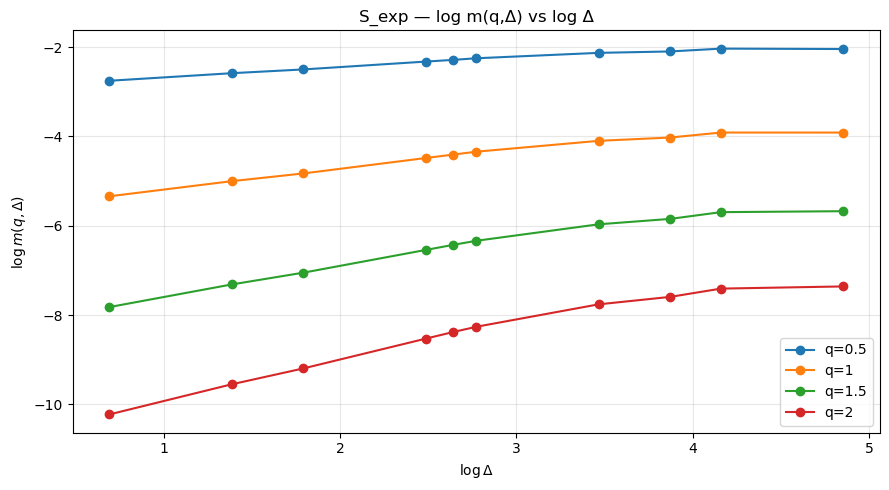

In [33]:
deltas = [2, 4, 6, 12, 14, 16,32, 48, 64, 128]
qs = [0.5, 1.0, 1.5, 2.0]
# Calcul de m(q, delta)
log_m_exp, m_exp, deltas_used, qs_used = compute_log_mq_delta(
    X_exp,
    deltas,
    qs
)
plot_log_m_vs_log_delta(
    log_m_exp,
    deltas_used,
    qs_used,
    title="S_exp — log m(q,Δ) vs log Δ"
)

In [35]:
H_exp, slopes_exp = estimate_H_per_q(
    log_m_exp,
    deltas_used,
    qs_used,
    fit_range=(1, 16)
)

H_exp

{0.5: 0.4822801921625491,
 1.0: 0.47922285972629813,
 1.5: 0.4754794566701262,
 2.0: 0.47157081507839055}

## S_frac case

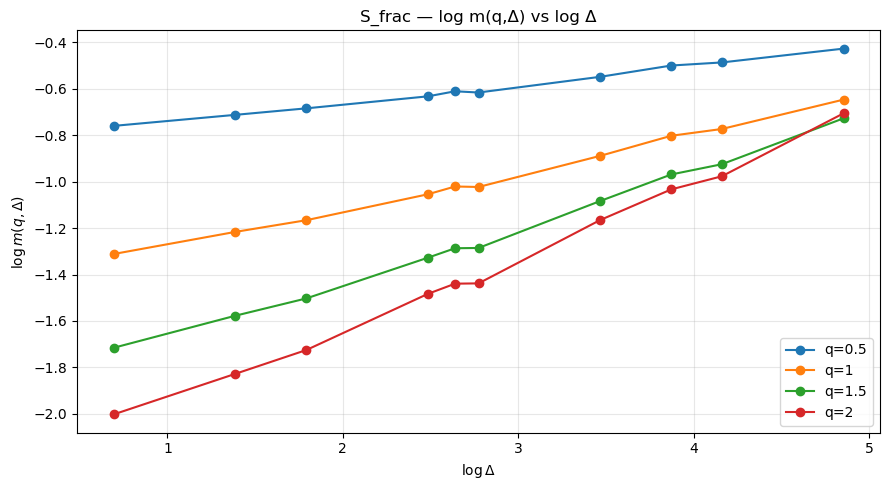

In [40]:
deltas = [2, 4, 6, 12, 14, 16,32, 48, 64, 128]

log_m_frac, m_frac, deltas_used, qs_used = compute_log_mq_delta(X_frac, deltas, qs)
plot_log_m_vs_log_delta(
    log_m_frac,
    deltas_used,
    qs_used,
    title="S_frac — log m(q,Δ) vs log Δ"
)

In [42]:
H_frac, slopes_frac = estimate_H_per_q(
    log_m_frac, deltas_used, qs_used, fit_range=(1, 16)
)
H_frac

{0.5: 0.14544455528356673,
 1.0: 0.14493564325466346,
 1.5: 0.1443851149603036,
 2.0: 0.14351633048961676}

## S_shift case

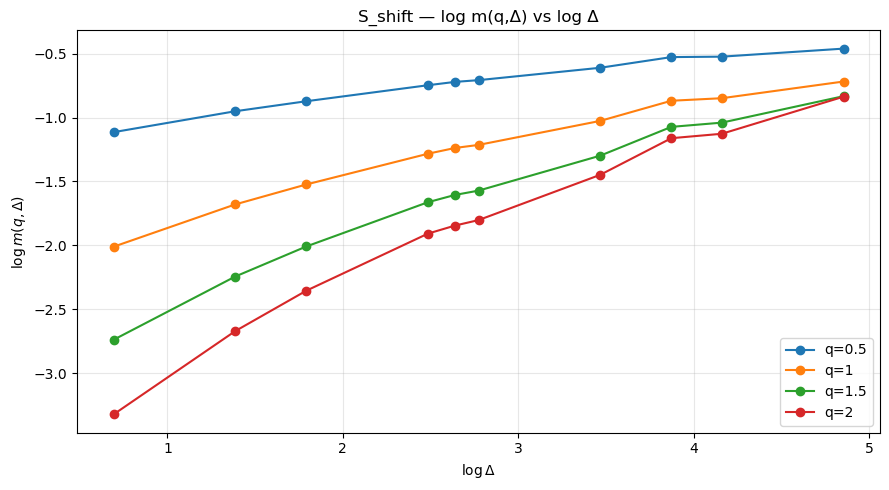

In [44]:
log_m_shift, m_shift, deltas_used, qs_used = compute_log_mq_delta(X_shift, deltas, qs)
plot_log_m_vs_log_delta(
    log_m_shift,
    deltas_used,
    qs_used,
    title="S_shift — log m(q,Δ) vs log Δ"
)

In [47]:
H_shift, slopes_shift = estimate_H_per_q(
    log_m_shift, deltas_used, qs_used, fit_range=(1, 16)
)
H_shift

{0.5: 0.38944645117327586,
 1.0: 0.3805631071305143,
 1.5: 0.3712764617499429,
 2.0: 0.36279652345946856}

### General Comment on the Log–Log Plots

The previous figures display the curves $\log m(q,\Delta)$ as a function of $\log \Delta$ for the three kernels under consideration.

In each case, we observe an approximately linear growth over an intermediate range of $\Delta$, suggesting a power-law behavior of the form
$$
m(q,\Delta) \sim C_q \Delta^{qH}.
$$

The slopes differ across kernels: the exponential model exhibits the steepest slopes, the fractional model the smallest, while the shifted model lies in between. This hierarchy is consistent with the theoretical regularity levels of the simulated volatility processes.

We also observe a slight flattening at larger scales, which is related to the mean-reversion inherent in the dynamics. This indicates that the pure scaling regime holds only over a limited range of $\Delta$, making the estimation of $H$ sensitive to the choice of the regression window.

This illustrates that apparent roughness may depend strongly on the scale of observation.

### Comparison between $H_{\text{skew}}$ (implicit) and $\widehat H$ (trajectory-based)

We now compare the implicit exponent $H_{\text{skew}}$, obtained from the short-maturity ATM skew calibration, with the exponent $\widehat H$ estimated statistically from simulated trajectories of the spot volatility $\sigma = \sqrt{V}$.

- **Exponential model $S_{\exp}$ (Markovian)**:  
  We have $H_{\text{skew}} = 0.5$ and $\widehat H \approx 0.48$. The agreement is globally satisfactory. The slight discrepancy can be attributed to finite-sample effects and to the fact that the scaling relation only holds over a restricted range of $\Delta$. In particular, mean-reversion affects the behavior at larger scales, which justifies restricting the regression window to $\Delta \in [1,16]$. When focusing on short scales, the estimated exponent is consistent with the Brownian regularity expected in the classical Heston setting.

- **Fractional model $S_{\text{frac}}$**: 
  The skew calibration yields $H_{\text{skew}} \approx 0.243$, whereas the trajectory-based estimation gives $\widehat H \approx 0.14$. This indicates that the empirical roughness measured from finite simulated paths appears stronger (i.e., smaller $H$) than the asymptotic short-maturity exponent suggested by option prices. This discrepancy highlights the distinction between (i) asymptotic small-maturity behavior derived from implied volatility expansions and (ii) statistical scaling observed over finite time grids and horizons. Discretization, proxy construction, and finite sampling all contribute to this difference.

- **Shifted model $S_{\text{shift}}$**:  
  Although the short-maturity skew calibration produces $H_{\text{skew}} < 0$, the empirical estimation gives $\widehat H \approx 0.38$. The positive shift parameter $\alpha > 0$ regularizes the kernel near zero and effectively introduces a short-scale cut-off. As a consequence, at any finite time resolution, the process does not exhibit the extreme hyper-rough behavior implied by the asymptotic exponent. The statistical estimator therefore captures an effective regularity that is substantially higher than the asymptotic one.

These findings qualitatively confirm the conclusions of Abi Jaber and Li (2024, Section 6). In particular, they show that statistical estimation of the Hurst exponent based on finite trajectories—or on volatility proxies—may be strongly influenced by discretization, mean-reversion, and the scale of observation.

More fundamentally, our results suggest that observing empirically $\widehat H < 0.5$ does not, by itself, constitute evidence that the underlying spot volatility process is intrinsically rough. Even a Markovian model with no fractional memory structure can produce trajectory-based estimates of roughness below $0.5$ over certain ranges of scales. Conversely, a model that is asymptotically hyper-rough may not appear extremely irregular when observed on a finite grid.

From an option pricing perspective, this distinction is crucial. Rough volatility models imply specific short-maturity asymptotics for implied volatility smiles and skews, as well as particular behaviors for forward variance dynamics and hedging sensitivities. If one incorrectly infers intrinsic roughness from statistical estimators alone, one may adopt a rough model that overstates short-term memory effects, leading to mispricing of short-dated options or miscalibration of volatility-of-volatility parameters. Conversely, dismissing roughness too quickly could underestimate the curvature and dynamics of the implied volatility surface at small maturities.

In summary, statistical roughness should not be used in isolation as a decisive model selection criterion. A coherent assessment must combine option-implied asymptotics, trajectory-based analysis, and economic interpretation of the underlying dynamics. Our numerical experiment illustrates that the apparent roughness of volatility is highly scale-dependent and may arise as an effective property rather than an intrinsic structural feature of the model.